<a href="https://colab.research.google.com/github/shivamahirwal/Stock-Price-Forecasting/blob/main/zeel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Forecasting for Zee Entertainment Enterprises Ltd

In [ ]:
# mounting drive
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/My Drive/Data/Samples

/content/drive/My Drive/Data/Samples


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('zeel.csv')

In [ ]:
df.head()

,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
0,31-March-2020,128.0,131.15,123.15,124.00,127.119757,1625130,4266,206586131.0,1439961.0,88.61,8.00,-4.00
1,30-March-2020,126.7,135.00,122.65,125.60,128.609928,273083,4397,35121185.0,39267.0,14.38,12.35,-1.10
2,27-March-2020,129.0,139.50,127.00,128.05,132.415284,254652,4253,33719817.0,35451.0,13.92,12.50,-0.95
3,26-March-2020,125.7,133.00,119.05,128.80,127.846681,360210,5269,46051653.0,48844.0,13.56,13.95,3.10
4,25-March-2020,118.0,129.90,114.00,125.70,121.078250,351411,5435,42548229.0,30548.0,8.69,15.90,7.70


In [ ]:
df['datetime']  = pd.to_datetime(df["Date"],format="%d-%B-%Y")

In [ ]:
df.head()

,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,datetime
0,31-March-2020,128.0,131.15,123.15,124.00,127.119757,1625130,4266,206586131.0,1439961.0,88.61,8.00,-4.00,2020-03-31
1,30-March-2020,126.7,135.00,122.65,125.60,128.609928,273083,4397,35121185.0,39267.0,14.38,12.35,-1.10,2020-03-30
2,27-March-2020,129.0,139.50,127.00,128.05,132.415284,254652,4253,33719817.0,35451.0,13.92,12.50,-0.95,2020-03-27
3,26-March-2020,125.7,133.00,119.05,128.80,127.846681,360210,5269,46051653.0,48844.0,13.56,13.95,3.10,2020-03-26
4,25-March-2020,118.0,129.90,114.00,125.70,121.078250,351411,5435,42548229.0,30548.0,8.69,15.90,7.70,2020-03-25


In [ ]:
for i in [df]:
    i['year'] = i.datetime.dt.year
    i['month'] = i.datetime.dt.month
    i['day'] = i.datetime.dt.day
    i['hour'] = i.datetime.dt.hour
    i['minute'] = i.datetime.dt.minute
    i['second'] = i.datetime.dt.second
    

In [ ]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df['datetime']
    df.index = df['date']
    df['minute'] = df['date'].dt.minute
    df['hour'] = df['date'].dt.hour
    df['dayofmonth'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['minute','hour','dayofmonth','month','dayofweek','quarter','year',
           'dayofyear','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='Close Price')

features_and_target = pd.concat([X, y], axis=1)

In [ ]:
features_and_target.head()

,minute,hour,dayofmonth,month,dayofweek,quarter,year,dayofyear,weekofyear,Close Price
date,,,,,,,,,,
2020-03-31,0,0,31,3,1,1,2020,91,14,124.00
2020-03-30,0,0,30,3,0,1,2020,90,14,125.60
2020-03-27,0,0,27,3,4,1,2020,87,13,128.05
2020-03-26,0,0,26,3,3,1,2020,86,13,128.80
2020-03-25,0,0,25,3,2,1,2020,85,13,125.70


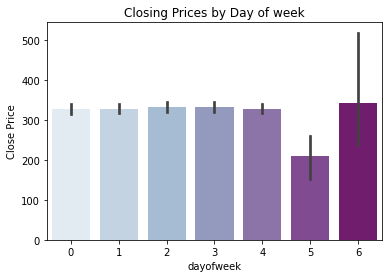

In [ ]:
# Closing Prices by day of the week
ax = plt.axes()
sns.barplot(x="dayofweek", y='Close Price', data=features_and_target, palette="BuPu", ax = ax)
ax.set_title('Closing Prices by Day of week')
plt.show()

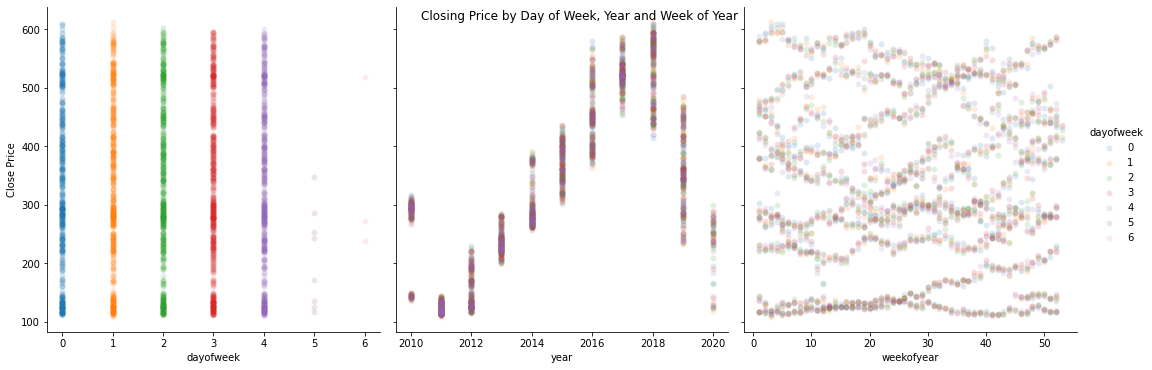

In [ ]:
sns.pairplot(features_and_target.dropna(),  
             hue='dayofweek',
             x_vars=['dayofweek',
                     'year','weekofyear'],
             y_vars='Close Price',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Closing Price by Day of Week, Year and Week of Year')
plt.show()

In [ ]:
a = df[df['year'] == 2019]
a[a['month'] == 3].head(5)

,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open,datetime,year,month,day,hour,minute,second
247,29-March-2019,444.25,453.45,437.25,444.30,445.664743,303621,4691,135313175.0,37091.0,12.22,16.20,0.05,2019-03-29,2019,3,29,0,0,0
248,28-March-2019,426.00,444.35,426.00,441.90,434.875207,369027,5387,160480693.0,61063.0,16.55,18.35,15.90,2019-03-28,2019,3,28,0,0,0
249,27-March-2019,423.95,428.35,419.80,424.20,424.043301,273965,3569,116173023.0,49702.0,18.14,8.55,0.25,2019-03-27,2019,3,27,0,0,0
250,26-March-2019,418.00,427.05,416.65,422.30,422.372129,298222,4743,125960661.0,40060.0,13.43,10.40,4.30,2019-03-26,2019,3,26,0,0,0
251,25-March-2019,434.00,439.95,414.90,417.25,422.409604,523413,7135,221094678.0,172243.0,32.91,25.05,-16.75,2019-03-25,2019,3,25,0,0,0


## Forecasting with considering values from 2010 to 2019 and testing from 2019 to 2020

In [ ]:
split_date = '2019-03-29'
train = df.loc[df.datetime < split_date].copy()
test = df.loc[df.datetime >= split_date].copy()

In [ ]:
model = Prophet()
model.fit(train.reset_index() \
              .rename(columns={'datetime':'ds',
                               'Close Price':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Predict on training set with model
test_fcst = model.predict(df=test.reset_index() \
                                   .rename(columns={'datetime':'ds'}))

In [ ]:
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-03-29,470.987340,422.830937,499.705457,470.987340,470.987340,-8.866982,-8.866982,-8.866982,-2.525325,-2.525325,-2.525325,-6.341657,-6.341657,-6.341657,0.0,0.0,0.0,462.120358
1,2019-04-01,470.594720,422.175724,500.168518,470.594720,470.594720,-9.050173,-9.050173,-9.050173,-2.337586,-2.337586,-2.337586,-6.712587,-6.712587,-6.712587,0.0,0.0,0.0,461.544547
2,2019-04-02,470.463847,426.067658,499.835592,470.463847,470.463847,-9.391614,-9.391614,-9.391614,-2.567455,-2.567455,-2.567455,-6.824159,-6.824159,-6.824159,0.0,0.0,0.0,461.072234
3,2019-04-03,470.332974,423.320631,502.267693,470.332974,470.332974,-8.791079,-8.791079,-8.791079,-1.862043,-1.862043,-1.862043,-6.929035,-6.929035,-6.929035,0.0,0.0,0.0,461.541896
4,2019-04-04,470.202101,423.736829,501.535863,470.202101,470.202101,-8.988943,-8.988943,-8.988943,-1.962411,-1.962411,-1.962411,-7.026532,-7.026532,-7.026532,0.0,0.0,0.0,461.213159


In [ ]:
test_fcst.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

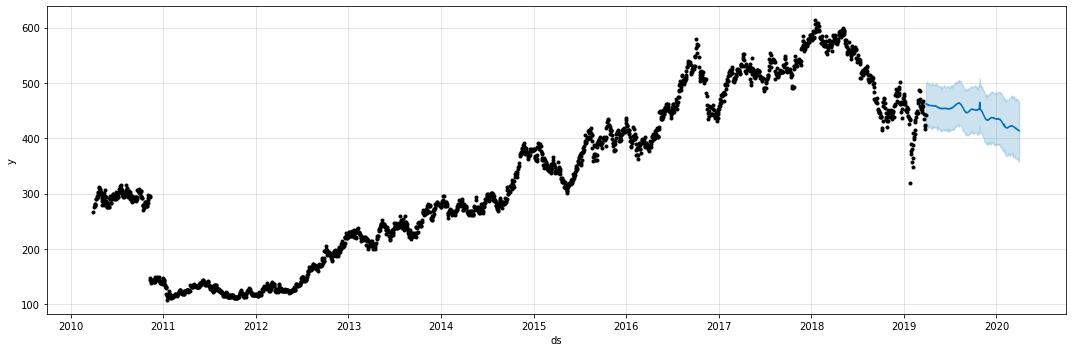

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_fcst, ax=ax)
plt.show()

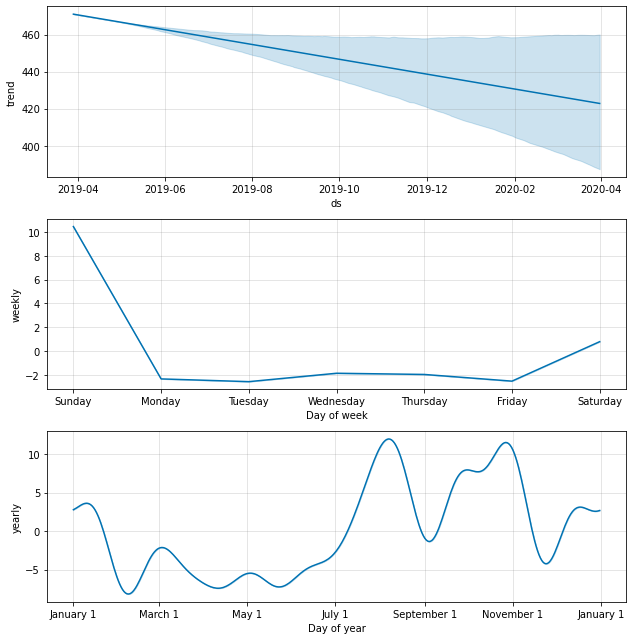

In [ ]:
# Plot the components of the model
fig = model.plot_components(test_fcst)

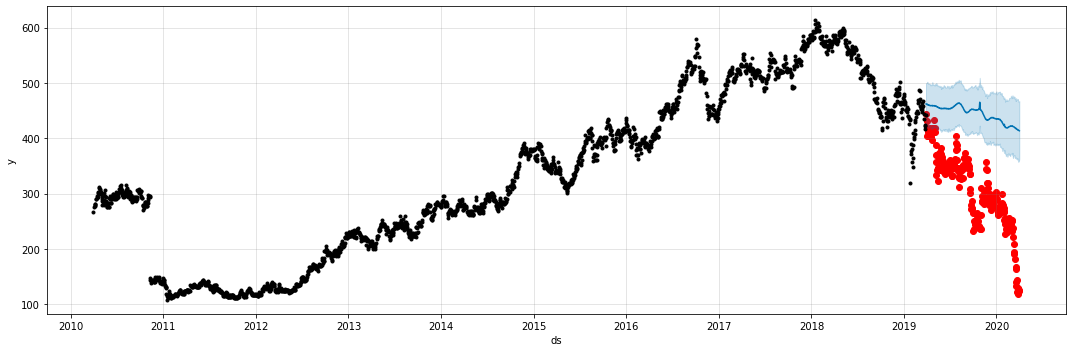

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test['datetime'], test['Close Price'], color='r')
fig = model.plot(test_fcst, ax=ax)
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
mean_absolute_percentage_error(y_true=test['Close Price'],
                   y_pred=test_fcst['yhat'])

55.84126665427007

## Forecasting with considering values from 2010 to 2016 and testing from 2016 to 2018

This is done to see the results keeping in mind the change in trend after 2018

In [ ]:
split_date = '2016-03-31'
end_date = '2018-03-31'
train = df.loc[df.datetime < split_date].copy()
test = df.loc[df.datetime >= split_date].copy()
test = test.loc[test.datetime <= end_date].copy()

In [ ]:
model = Prophet()
model.fit(train.reset_index() \
              .rename(columns={'datetime':'ds',
                               'Close Price':'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Predict on training set with model
test_fcst = model.predict(df=test.reset_index() \
                                   .rename(columns={'datetime':'ds'}))

In [ ]:
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-03-31,404.598201,368.492073,412.499022,404.598201,404.598201,-13.610193,-13.610193,-13.610193,-0.574638,-0.574638,-0.574638,-13.035554,-13.035554,-13.035554,0.0,0.0,0.0,390.988008
1,2016-04-01,404.719426,368.926461,411.908114,404.719426,404.719426,-13.756687,-13.756687,-13.756687,-0.189981,-0.189981,-0.189981,-13.566706,-13.566706,-13.566706,0.0,0.0,0.0,390.962739
2,2016-04-04,405.083101,368.623352,411.562817,405.083101,405.083101,-15.141180,-15.141180,-15.141180,-0.218615,-0.218615,-0.218615,-14.922564,-14.922564,-14.922564,0.0,0.0,0.0,389.941921
3,2016-04-05,405.204326,367.685474,409.958712,405.204326,405.204326,-15.914264,-15.914264,-15.914264,-0.632689,-0.632689,-0.632689,-15.281575,-15.281575,-15.281575,0.0,0.0,0.0,389.290063
4,2016-04-06,405.325551,367.062607,412.093033,405.325551,405.325551,-15.339900,-15.339900,-15.339900,0.249715,0.249715,0.249715,-15.589614,-15.589614,-15.589614,0.0,0.0,0.0,389.985652


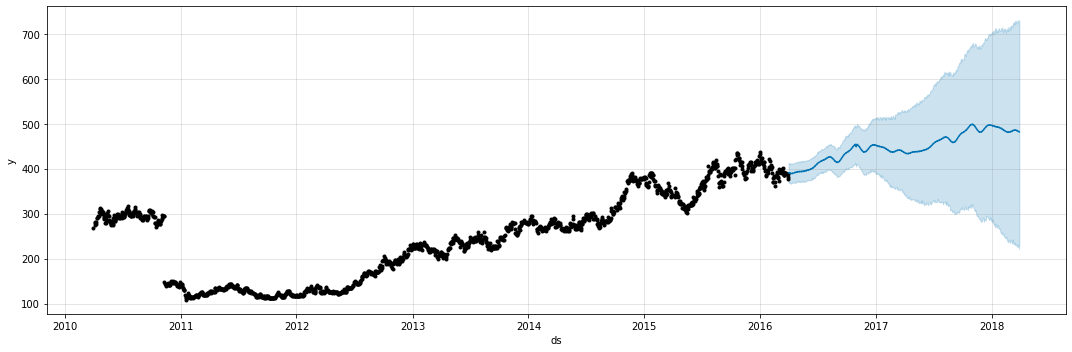

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_fcst, ax=ax)
plt.show()

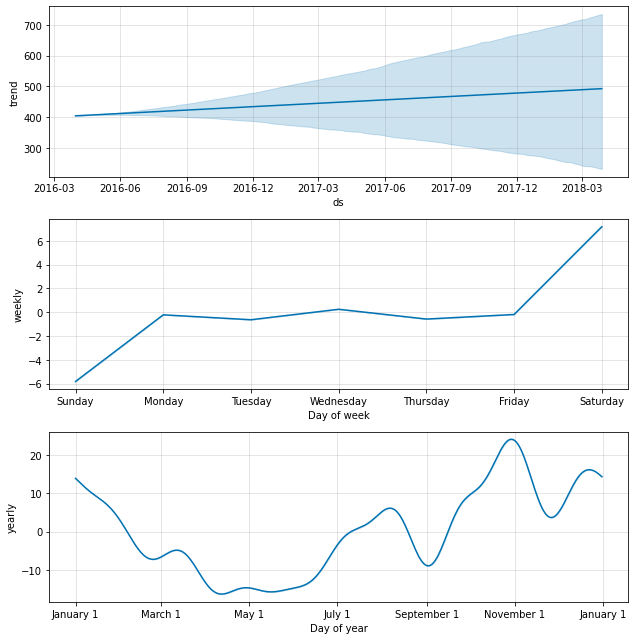

In [ ]:
# Plot the components of the model
fig = model.plot_components(test_fcst)

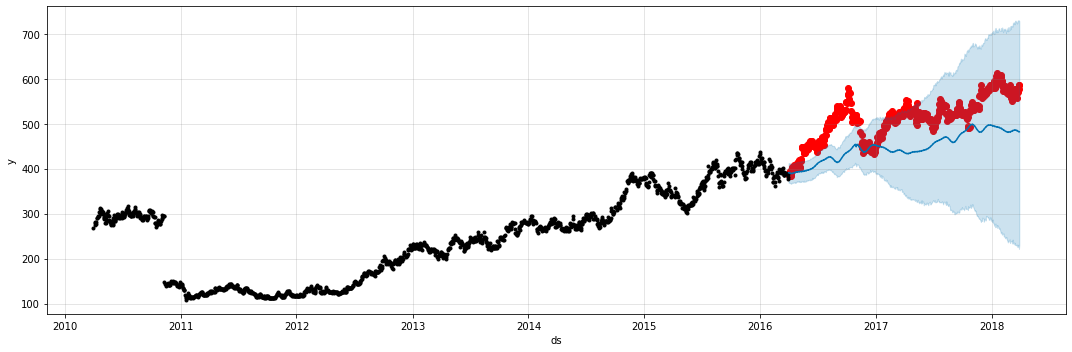

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test['datetime'], test['Close Price'], color='r')
fig = model.plot(test_fcst, ax=ax)
plt.show()

In [ ]:
mean_absolute_percentage_error(y_true=test['Close Price'],
                   y_pred=test_fcst['yhat'])

15.382514566026284